In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from utils import LogitsToPredicate, MLP, MultiKANModel, DataLoader, DataLoaderMulti
from kan import KAN

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

X_columns = [
    'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 
    # 'Drate',
    # 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    # 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count',
    # 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
    # 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 
    'IPv','LLC', 
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
    'Magnitue', 'Radius', 'Covariance',
    # 'Variance', 'Weight'
]

Y_columns = ['label_L1', 'label_L2']

label_L1_mapping = {"MQTT": 0, "Benign": 1} 
label_L2_mapping = {"MQTT-DDoS-Connect_Flood": 0, "MQTT-DDoS-Publish_Flood": 1, 
                    "MQTT-DoS-Connect_Flood": 2, "MQTT-DoS-Publish_Flood": 3,
                    "MQTT-Malformed_Data": 4, "Benign": 5} 
# Read the CSV file
df = pd.read_csv('/home/zyang44/Github/baseline_cicIOT/CIC_IoMT/19classes/filtered_train_l_2_6.csv')
df['label_L1'] = df['label_L1'].map(label_L1_mapping)
df['label_L2'] = df['label_L2'].map(label_L2_mapping)

# Shuffle the dataframe before splitting into training and test sets
df = df.sample(frac=1, random_state=42)
# 90% as training set and 10% as test set
train_size = int(len(df) * 0.9)
train_df, test_df = df.iloc[:train_size, :], df.iloc[train_size:, :]

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_df[X_columns])
test_X_scaled = scaler.transform(test_df[X_columns])
print("Any NaN in test_X_scaled:", np.isnan(test_X_scaled).any())
print("Any Inf in test_X_scaled:", np.isinf(test_X_scaled).any())

train_y = train_df[Y_columns].values
test_y = test_df[Y_columns].values
print("Unique train_y values:", np.unique(train_y[:, 0]), np.unique(train_y[:, 1]))
print("Unique test_y values:", np.unique(test_y[:, 0]), np.unique(test_y[:, 1]))

train_loader_multi = DataLoaderMulti(
    data=torch.tensor(train_X_scaled, dtype=torch.float32),
    labels=torch.tensor(train_y, dtype=torch.long),
    batch_size=len(train_df))
test_loader_multi = DataLoaderMulti(
    data=torch.tensor(test_X_scaled, dtype=torch.float32),
    labels=torch.tensor(test_y, dtype=torch.long),
    batch_size=len(test_df))

train_loader = DataLoader(
    data=torch.tensor(train_X_scaled, dtype=torch.float32, device=device),
    labels=torch.tensor(train_y[:, 1], dtype=torch.long, device=device),
    batch_size=len(train_df))
test_loader = DataLoader(
    data=torch.tensor(test_X_scaled, dtype=torch.float32, device=device),
    labels=torch.tensor(test_y[:, 1], dtype=torch.long, device=device),
    batch_size=len(test_df))


cuda:0
Any NaN in test_X_scaled: False
Any Inf in test_X_scaled: False
Unique train_y values: [0 1] [0 1 2 3 4 5]
Unique test_y values: [0 1] [0 1 2 3 4 5]


In [2]:
import ltn
import ltn.fuzzy_ops

# define the connectives, quantifiers, and the SatAgg
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())   # And = ltn.Connective(custom_fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
SatAgg = ltn.fuzzy_ops.SatAgg()

# define ltn constants
l_MQTT_DDoS_Connect_Flood = ltn.Constant(torch.tensor([1, 0, 0, 0, 0, 0]))
l_MQTT_DDoS_Publish_Flood = ltn.Constant(torch.tensor([0, 1, 0, 0, 0, 0]))
l_MQTT_DoS_Connect_Flood = ltn.Constant(torch.tensor([0, 0, 1, 0, 0, 0]))
l_MQTT_DoS_Publish_Flood = ltn.Constant(torch.tensor([0, 0, 0, 1, 0, 0]))
l_MQTT_Malformed_Data = ltn.Constant(torch.tensor([0, 0, 0, 0, 1, 0]))
l_Benign = ltn.Constant(torch.tensor([0, 0, 0, 0, 0, 1]))

# l_MQTT = ltn.Constant(torch.tensor([1,0]))
# l_Benign = ltn.Constant(torch.tensor([0,1]))

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def compute_accuracy(loader, model):
    total_correct = 0
    total_samples = 0
    for data, labels in loader:
        logits = model(data)
        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == labels).sum()
        total_samples += labels.numel()
    return total_correct.float() / total_samples


target_names_L2 = [
    "MQTT-DDoS-Connect_Flood",
    "MQTT-DDoS-Publish_Flood", 
    "MQTT-DoS-Connect_Flood",
    "MQTT-DoS-Publish_Flood",
    "MQTT-Malformed_Data",
    "Benign"
] 
def plot_confusion_matrix(loader, model):
    y_true = []
    y_pred = []
    for data, labels in loader:
        logits = model(data)
        preds = torch.argmax(logits, dim=1)
        y_true.extend(labels.tolist())
        y_pred.extend(preds.tolist())
    cm = confusion_matrix(y_true, y_pred)
    return cm

In [35]:

def compute_sat_levels(loader, P):
	sat_level  = 0
	for data, labels in loader:
		x = ltn.Variable("x", data)
		x_MQTT_DDoS_Connect_Flood = ltn.Variable("x_MQTT_DDoS_Connect_Flood", data[labels == 0])
		x_MQTT_DDoS_Publish_Flood = ltn.Variable("x_MQTT_DDoS_Publish_Flood", data[labels == 1])
		x_MQTT_DoS_Connect_Flood = ltn.Variable("x_MQTT_DoS_Connect_Flood", data[labels == 2])
		x_MQTT_DoS_Publish_Flood = ltn.Variable("x_MQTT_DoS_Publish_Flood", data[labels == 3])
		x_MQTT_Malformed_Data = ltn.Variable("x_MQTT_Malformed_Data", data[labels == 4])
		x_Benign = ltn.Variable("x_Benign", data[labels == 5])

		x_MQTT = ltn.Variable("x_MQTT", data[labels < 5])
		
		sat_level = SatAgg(
			Forall(x_MQTT_DDoS_Connect_Flood, P(x_MQTT_DDoS_Connect_Flood, l_MQTT_DDoS_Connect_Flood)),
			Forall(x_MQTT_DDoS_Publish_Flood, P(x_MQTT_DDoS_Publish_Flood, l_MQTT_DDoS_Publish_Flood)),
			Forall(x_MQTT_DoS_Connect_Flood, P(x_MQTT_DoS_Connect_Flood, l_MQTT_DoS_Connect_Flood)),
			Forall(x_MQTT_DoS_Publish_Flood, P(x_MQTT_DoS_Publish_Flood, l_MQTT_DoS_Publish_Flood)),
			Forall(x_MQTT_Malformed_Data, P(x_MQTT_Malformed_Data, l_MQTT_Malformed_Data)),
			Forall(x_Benign, P(x_Benign, l_Benign)),
			# hierarchical constraints
			Forall(x_MQTT, Not(P(x_MQTT, l_Benign)))
		)
	return sat_level


kan_h = KAN(width=[18, 6, 6, 6], grid=5, k=3, seed=42, device=device)
P_kan = ltn.Predicate(LogitsToPredicate(MultiKANModel(kan_h)))
optimizer_kan = torch.optim.Adam(P_kan.parameters(), lr=0.001)

# kan_h_L1 = KAN(width=[18, 6, 2], grid=5, k=3, seed=42, device=device)
# P_kan_L1 = ltn.Predicate(LogitsToPredicate(MultiKANModel(kan_h_L1)))
# params = list(P_kan.parameters()) + list(P_kan_L1.parameters())
# optimizer_2kan = torch.optim.Adam(params, lr=0.001)

kan_loss, kan_acc, kan_sat = [], [], []
for epoch in range(501):
    # Train the KAN
	optimizer_kan.zero_grad()
	sat_kan = compute_sat_levels(train_loader, P_kan)
	loss = 1. - sat_kan
	loss.backward()
	optimizer_kan.step()
	train_loss_kan = loss.item()

	# Test the KAN
	acc_kan = compute_accuracy(test_loader, kan_h)
	test_sat_kan = compute_sat_levels(test_loader, P_kan)
	kan_loss.append(train_loss_kan)
	kan_acc.append(acc_kan.item())
	kan_sat.append((sat_kan.item(), test_sat_kan.item())) # save the train/test sat in kan_sat
	if epoch % 10 == 0:
		print(f"Epoch {epoch}, Train Loss: {train_loss_kan:4f}, Test Accuracy: {acc_kan.item():4f}, Sat: {sat_kan.item():4f}/{test_sat_kan.item():4f}")


checkpoint directory created: ./model
saving model version 0.0
Epoch 0, Train Loss: 0.771725, Test Accuracy: 0.180771, Sat: 0.228275/0.228643
Epoch 10, Train Loss: 0.768632, Test Accuracy: 0.279419, Sat: 0.231368/0.231931
Epoch 20, Train Loss: 0.764718, Test Accuracy: 0.292939, Sat: 0.235282/0.236126
Epoch 30, Train Loss: 0.759571, Test Accuracy: 0.296445, Sat: 0.240429/0.241617
Epoch 40, Train Loss: 0.752849, Test Accuracy: 0.295443, Sat: 0.247151/0.248721
Epoch 50, Train Loss: 0.744289, Test Accuracy: 0.296945, Sat: 0.255711/0.257691
Epoch 60, Train Loss: 0.733957, Test Accuracy: 0.434902, Sat: 0.266043/0.268443
Epoch 70, Train Loss: 0.722024, Test Accuracy: 0.422384, Sat: 0.277976/0.280802
Epoch 80, Train Loss: 0.708039, Test Accuracy: 0.427892, Sat: 0.291961/0.295209
Epoch 90, Train Loss: 0.691891, Test Accuracy: 0.459940, Sat: 0.308109/0.311692
Epoch 100, Train Loss: 0.674079, Test Accuracy: 0.498247, Sat: 0.325921/0.329805
Epoch 110, Train Loss: 0.655134, Test Accuracy: 0.500000,

**MLP with CrossEntropyLoss**

In [ ]:
# Define the MLP predicate
mlp = MLP(layer_sizes=(18, 12, 6)).to(device)

# MLP with standard loss fn 
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

mlp_loss, mlp_acc = [], []
for epoch in range(401):
    optimizer.zero_grad()
    logits = mlp(train_loader.data, training=True)
    loss = criterion(logits, train_loader.labels)
    loss.backward()
    optimizer.step()

    # test
    acc = compute_accuracy(test_loader, mlp)
    mlp_loss.append(loss.item())
    mlp_acc.append(acc.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():4f}, Test accuracy: {acc.item():4f}")

Epoch 0, Loss: 1.864493, Test accuracy: 0.206059
Epoch 100, Loss: 1.473341, Test accuracy: 0.428393
Epoch 200, Loss: 1.288574, Test accuracy: 0.517276
Epoch 300, Loss: 1.145160, Test accuracy: 0.570856
Epoch 400, Loss: 1.030851, Test accuracy: 0.604407


In [32]:
font_size = 14

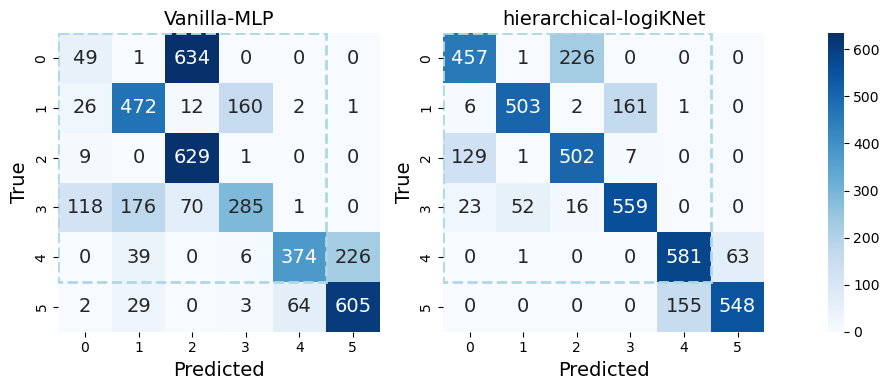

In [36]:
# plot the confusion matrix with shared color legend and labels for each subplot
cm_mlp = plot_confusion_matrix(test_loader, mlp)
cm_kan = plot_confusion_matrix(test_loader, kan_h)

import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

# Get common range for both heatmaps
vmin = min(cm_mlp.min(), cm_kan.min())
vmax = max(cm_mlp.max(), cm_kan.max())

fig = plt.figure(figsize=(9, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])
cbar_ax = fig.add_subplot(gs[2])

import seaborn as sns
# Plot the first heatmap with its colorbar assigned to cbar_ax
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap='Blues', annot_kws={'fontsize': font_size},
            vmin=vmin, vmax=vmax, ax=ax0, cbar=True, cbar_ax=cbar_ax)
ax0.set_title("Vanilla-MLP", fontdict={'fontsize': font_size})
ax0.set_xlabel("Predicted", fontsize=font_size)
ax0.set_ylabel("True", fontsize=font_size)
ax0.add_patch(patches.Rectangle((0, 0), 5, 5, linewidth=2, edgecolor='lightblue', facecolor='none', linestyle='dashed'))

# Plot the second heatmap without its own colorbar
sns.heatmap(cm_kan, annot=True, fmt="d", cmap='Blues', annot_kws={'fontsize': font_size},
            vmin=vmin, vmax=vmax, ax=ax1, cbar=False)
ax1.set_title("hierarchical-logiKNet", fontdict={'fontsize': font_size})
ax1.set_xlabel("Predicted", fontsize=font_size)
ax1.set_ylabel("True", fontsize=font_size)
ax1.add_patch(patches.Rectangle((0, 0), 5, 5, linewidth=2, edgecolor='lightblue', facecolor='none', linestyle='dashed'))

plt.tight_layout()
# plt.show()
plt.savefig("./output/MLP_KAN_19classes.pdf", dpi=300, bbox_inches='tight', format='pdf')

In [38]:
# define a soft metric (reliable score) as an extension of the accuracy
# reliable score also care about the L1 level classification of the model, 
# if a case is predicted wrong in L2 level but correct in L1 level, it should be considered less penalty
# where the L1 level means the MQTT vs Benign classification, L2 level means the 5 MQTT classification + 1 Benign classification

def reliable_score(loader, model):
    reliable_score = 0
    for data, labels in loader:
        logits = model(data)
        preds = torch.argmax(logits, dim=1)
        for i in range(len(labels)):
            if labels[i] == preds[i]:
                reliable_score += 1
            else:
                if labels[i] <5 and preds[i] < 5:
                    reliable_score += 0.5
    return reliable_score / loader.batch_size

mlp_reliable_score = reliable_score(test_loader, mlp)
kan_reliable_score = reliable_score(test_loader, kan_h) 
print("MLP reliable score:", mlp_reliable_score)
print("KAN reliable score:", kan_reliable_score)


MLP reliable score: 0.7615172759138709
KAN reliable score: 0.8670505758637957
